### Check type of GPU and VRAM available.

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15109 MiB, 15109 MiB


## Install Requirements

In [2]:
# Clone repos we need
!git clone https://github.com/Jan-Oliver/profaile-pic-dev.git

Cloning into 'profaile-pic-dev'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 106 (delta 0), reused 2 (delta 0), pack-reused 102
Receiving objects: 100% (106/106), 32.89 MiB | 16.07 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [7]:
!cd /content/profaile-pic-dev && pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-b59oktg5
  Running command git clone -q https://github.com/huggingface/diffusers.git /tmp/pip-req-build-b59oktg5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47.4 MB 1.4 MB/s 
     |████████████████████████████████| 18.2 MB 202 kB/s 
     |████████████████████████████████| 191 kB 75.2 MB/s 
     |████████████████████████████████| 5.8 MB 64.8 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 62.5 MB 31 kB/s 
     |████████████████████████████████| 13.8 MB 56.1 MB/s 
     |████████████████████████████████| 182 kB 76.2 MB/s 
     |████████████████████████████████| 7.6 MB 63.5 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |███

## Set up W&B and GDrive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download model structure to local directory

- We have to do this once and push the model structure to AWS S3 bucket. From there we can then a) simply specify the path to the model in S3 bucket or b) download it each time to sagemaker before run. I am not sure which option is better / how to do it exactly but should be possible.
- Another option would be to specify the path at Huggingface but I am in favour of not doing that as Hugging sometimes fucks up the download. Also, the code does not support this at the moment.

In [6]:
!git lfs install
!git clone https://huggingface.co/stabilityai/stable-diffusion-2-depth
!git clone https://huggingface.co/stabilityai/stable-diffusion-2-base
!git clone https://huggingface.co/stabilityai/sd-vae-ft-mse

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'stable-diffusion-2-depth'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 90 (delta 24), reused 0 (delta 0), pack-reused 9
Unpacking objects: 100% (90/90), done.
tcmalloc: large alloc 1471086592 bytes == 0x55728be54000 @  0x7ff52185a2a4 0x55724f99578f 0x55724f9728db 0x55724f9275b3 0x55724f8cb34a 0x55724f8cb806 0x55724f8e8ad1 0x55724f8e9069 0x55724f8e9593 0x55724f98e482 0x55724f82ecc2 0x55724f815a75 0x55724f816735 0x55724f81573a 0x7ff520ba1c87 0x55724f81578a
tcmalloc: large alloc 1471086592 bytes == 0x55728be54000 @  0x7ff52185a2a4 0x55724f99578f 0x55724f9728db 0x55724f9275b3 0x55724f8cb34a 0x55724f8cb806 0x55724f8e8ad1 0x55724f8e9069 0x55724f8e9593 0x55724f98e482 0x55724f82ecc2 0x55724f815a75 0x55724f816735 0x55724f8

In [8]:
import shutil
import glob
import tqdm 
import os

In [10]:
GENDER = "man"

PRETRAINED_DEPTH_MODEL_PATH = "/content/stable-diffusion-2-depth"
PRETRAINED_BASE_MODEL_PATH = "/content/stable-diffusion-2-base"
PRETRAINED_VAE_MODEL_PATH = "/content/sd-vae-ft-mse"
INSTANCE_IMAGES_DIR = "/content/data/instance_images"
CLASS_IMAGES_DIR = "/content/data/class_images"
MODEL_OUTPUT_DIR = "/content/model"

In [17]:
os.makedirs(INSTANCE_IMAGES_DIR, exist_ok=True)
os.makedirs(CLASS_IMAGES_DIR, exist_ok=True)
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

# Copy instance files from 
for filename in tqdm.tqdm(glob.glob(os.path.join("/content/drive/MyDrive/StableDiffusion/pictures_manap", '*.*'))):
  shutil.copy(filename, INSTANCE_IMAGES_DIR)

for filename in tqdm.tqdm(glob.glob(os.path.join("/content/drive/MyDrive/StableDiffusion/class_pictures_man", '*.*'))):
  shutil.copy(filename, CLASS_IMAGES_DIR)

100%|██████████| 324/324 [00:07<00:00, 45.90it/s] 


In [ ]:
!accelerate launch --mixed_precision=fp16 --num_processes=2 /content/profaile-pic-dev/dreambooth/train.py \
    --model_output_dir=$MODEL_OUTPUT_DIR \
    --pretrained_depth_model_path=$PRETRAINED_DEPTH_MODEL_PATH \
    --pretrained_base_model_path=$PRETRAINED_BASE_MODEL_PATH \
    --pretrained_vae_path=$PRETRAINED_VAE_MODEL_PATH \
    --instance_data_dir=$INSTANCE_DATA_DIR \
    --class_data_dir=$CLASS_DATA_DIR \
    --instance_prompt="Photo of qonvhs man" \
    --class_prompt="Photo of man" \
    --with_prior_preservation \
    --prior_loss_weight=1.0 \
    --num_class_images=324 \
    --class_batch_size=4 \
    --seed=1337 \
    --train_text_encoder \
    --train_batch_size=1 \
    --max_train_steps=3500 \
    --learning_rate=1e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_step=0 \
    --gradient_accumulation_steps=1 \
    --mixed_precision="fp16" \
    --gradient_checkpointing \
    --use_8bit_adam

	`--num_machines` was set to a value of `1`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Some weights of the model checkpoint at /content/stable-diffusion-2-depth were not used when initializing DPTForDepthEstimation: ['dpt.embeddings.backbone.bit.encoder.stages.2.layers.6.conv2.weight', 'dpt.embeddings.backbone.bit.encoder.stages.2.layers.7.conv3.weight', 'dpt.embeddings.backbone.bit.encoder.stages.2.layers.6.norm1.weight', 'dpt.embeddings.backbone.bit.encoder.stages.0.layers.1.norm2.weight', 'dpt.embeddings.backbone.bit.encoder.stages.2.layers.7.norm1.bias', 'dpt.embeddings.backbone.bit.encoder.stages.1.layers.1.conv3.weight', 'dpt.embeddings.backbone.bit.encoder.stages.1.layers.0.norm1.weight', 'dpt.embeddings.backbone.bit.encoder.stages.2.layers.0.downsample.conv.weight', 'dpt.embeddings.backbone.bit.encoder.stages.2.layers.0.conv3.weight', 'dpt.embeddings.backbone.bit.encode

### Preview the results

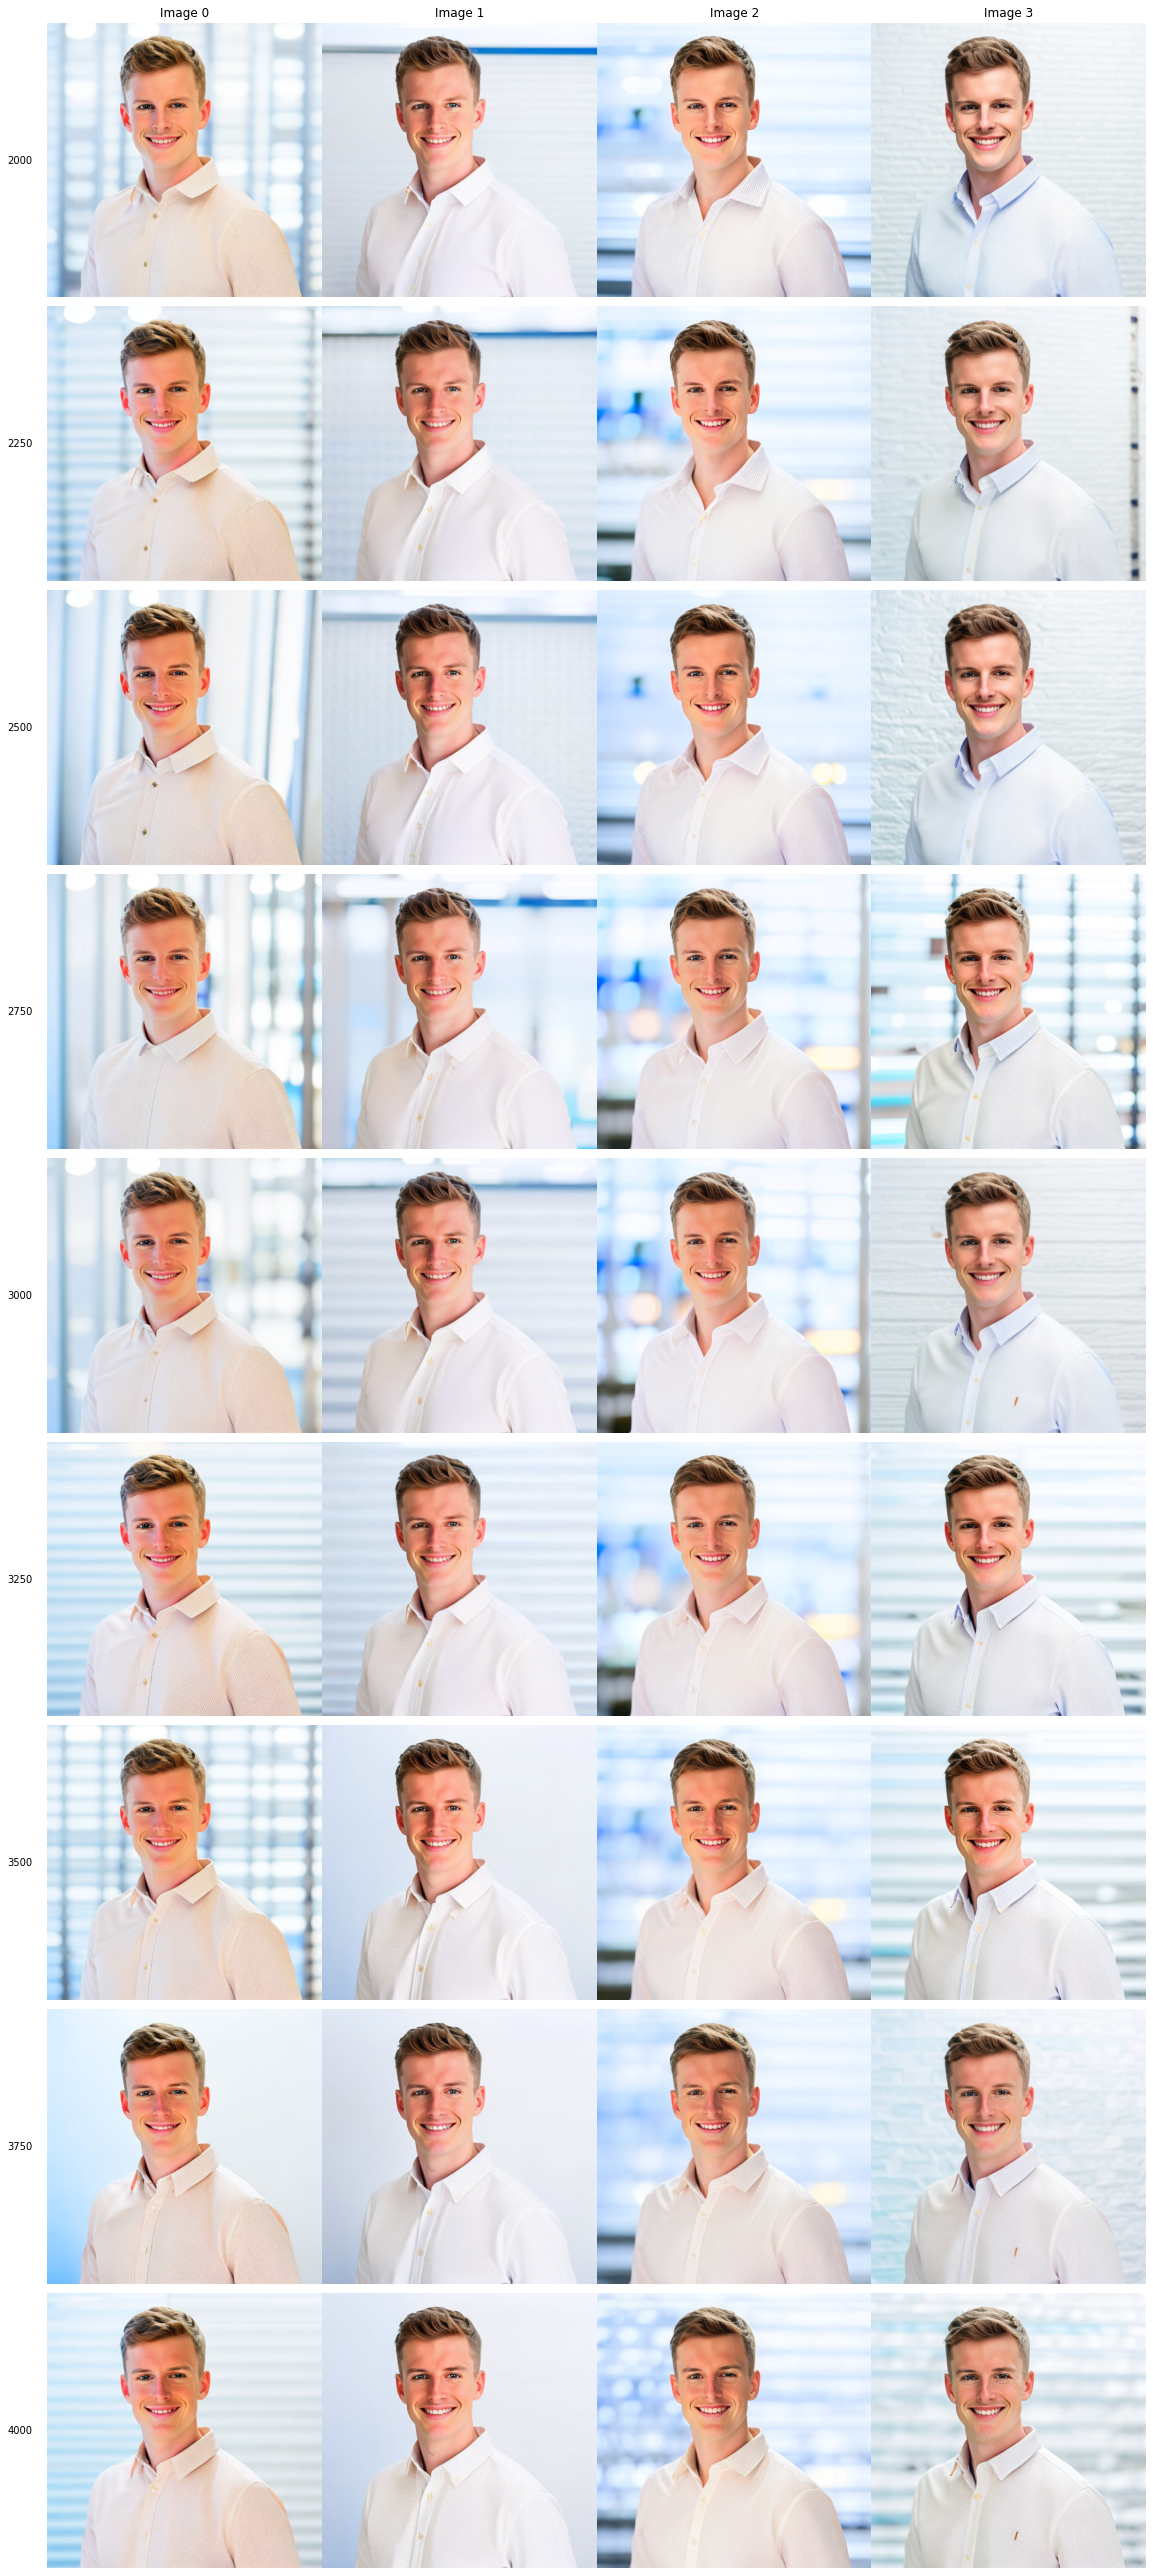

In [15]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = MODEL_OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig('grid.png', dpi=72)

### Inference

In [16]:
# Util functions
from PIL import Image
PRECISION="fp16"
if PRECISION == "fp16":
    fp16 = True
else:
    fp16 = False

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [19]:
# Useful later when we actually use the depth2img model
DEPTH2IMG_DIR = "/content/inference/depth2img"
!mkdir $DEPTH2IMG_DIR

In [20]:
for filename in glob.glob(os.path.join("/content/drive/MyDrive/StableDiffusion/pictures_depth2img", '*.*')):
    shutil.copy(filename, DEPTH2IMG_DIR)

### Which weights should be loaded?

In [33]:
WEIGHTS_DIR = os.path.join(OUTPUT_DIR, "2500")
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=/content/stable_diffusion_weights/train/2500


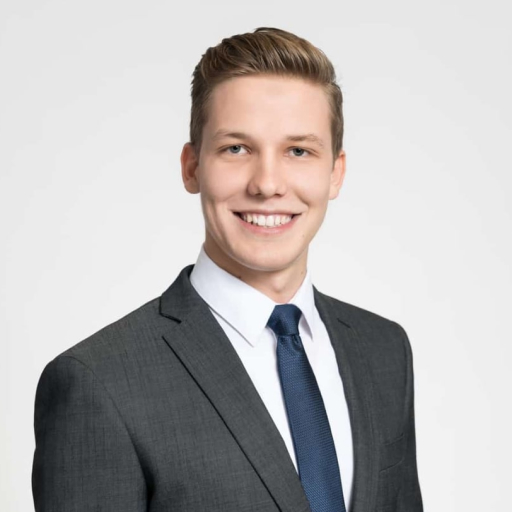

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionDepth2ImgPipeline and will be ignored.


In [36]:
import torch
from torch import autocast
from diffusers import StableDiffusionDepth2ImgPipeline, DDIMScheduler, EulerDiscreteScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

from IPython.display import display
import requests
from PIL import Image


url = "https://ca.slack-edge.com/TUTJQ5RNV-U02P1ET637V-7d91d73a4fd4-512"
init_image = Image.open(requests.get(url, stream=True).raw)
init_image = Image.open("/content/inference/depth2img/Kopie von 1_mann_blond_27.jpg")
display(init_image)
scheduler_euler = EulerDiscreteScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
scheduler_ddim = DDIMScheduler.from_pretrained(MODEL_NAME,subfolder="scheduler")

# First for Euler
if fp16:
  pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(model_path, scheduler=scheduler_ddim, safety_checker=None, torch_dtype=torch.float16).to("cuda")
else:
  pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(model_path, scheduler=scheduler_ddim, safety_checker=None, torch_dtype=torch.float32).to("cuda")

# Then for DDIM
g_cuda = torch.Generator(device='cuda').manual_seed(52362)

Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', hasselblad, candid street portrait']


  0%|          | 0/57 [00:00<?, ?it/s]

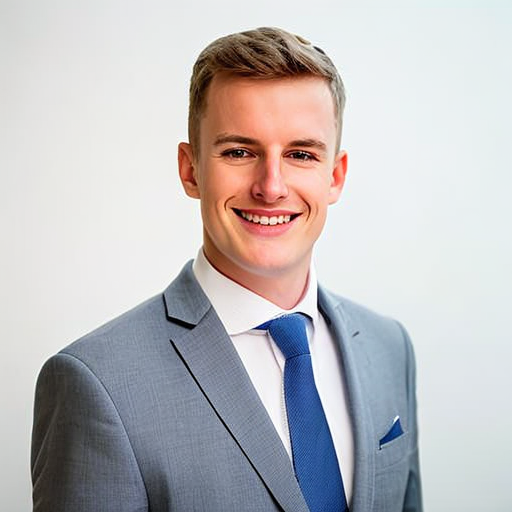

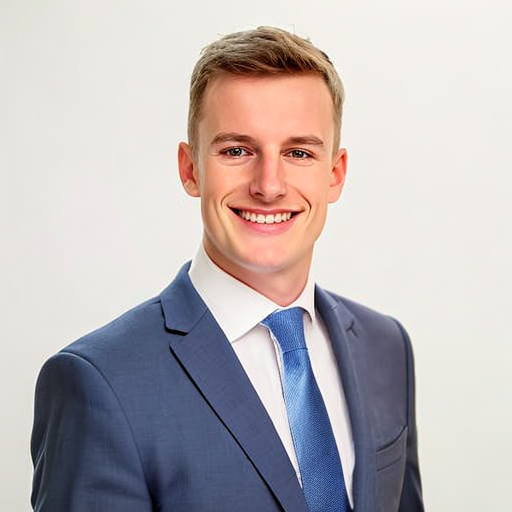

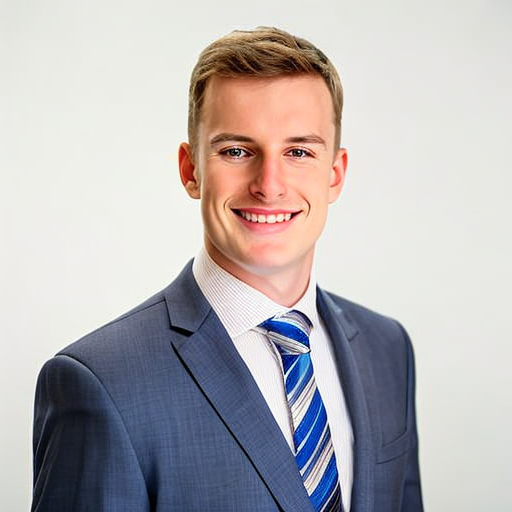

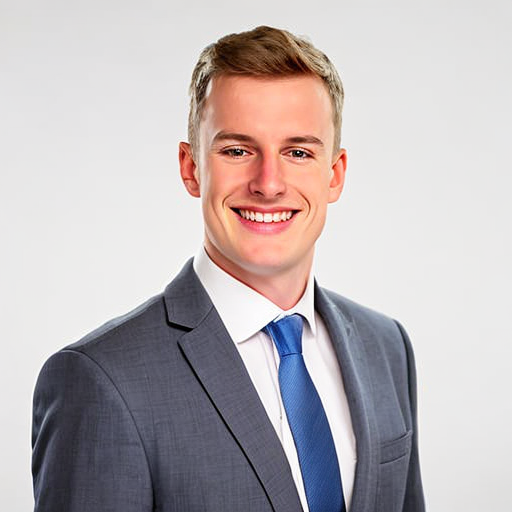

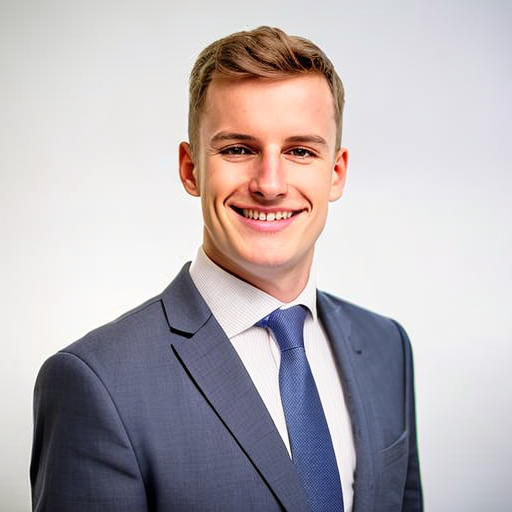

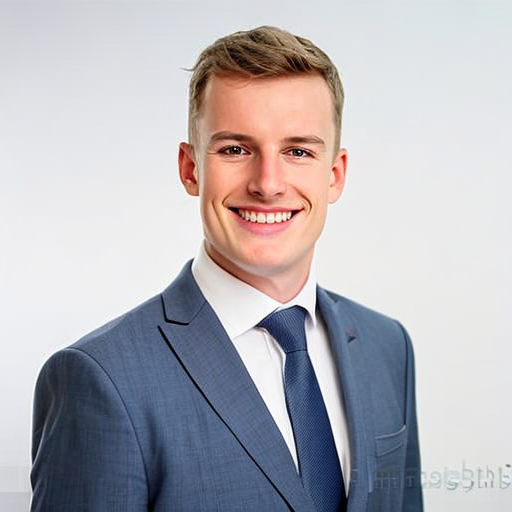

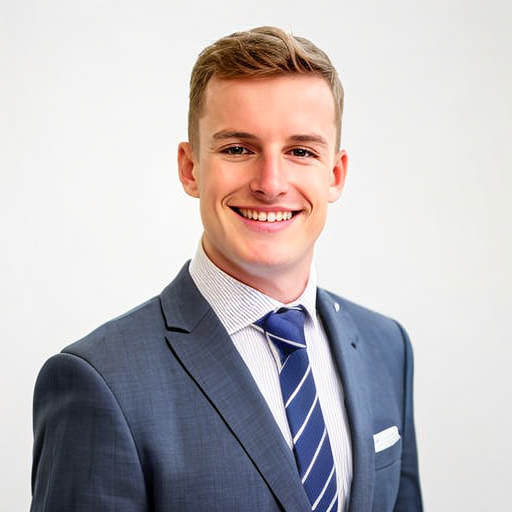

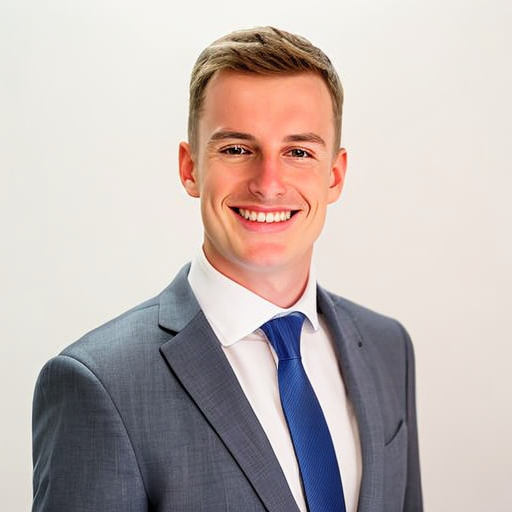

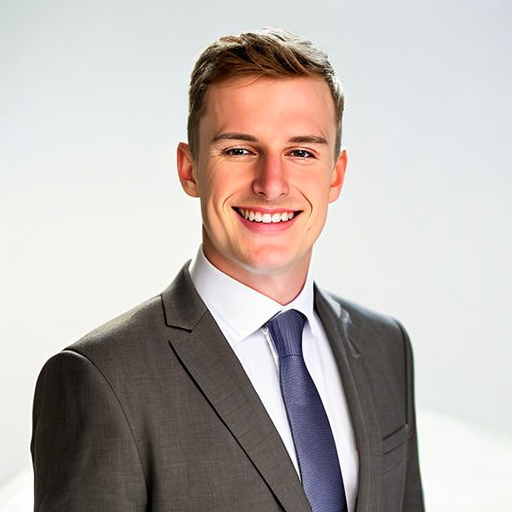

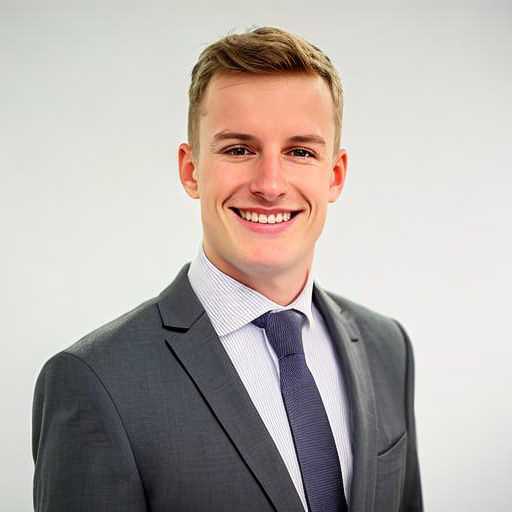

In [37]:
prompt = "portrait of tseidenfuss man with a perfect smile, perfect eyes, front view, closeup, centered frame, symmetric, studio lighting, clear and realistic face, uhd faces, pexels, 85mm, casual pose, 35mm film roll photo, hard light, detailed skin texture, masterpiece, sharp focus, pretty, lovely, adorable, attractive, hasselblad, candid street portrait"
negative_prompt = "blender, jewlery, chain,ugly, different eye color ,multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
num_samples = 10
guidance_scale = 7
num_inference_steps = 70
height = 512
width = 512

images = pipe(
    prompt=prompt,
    image=init_image,
    strength=0.825,
    negative_prompt=negative_prompt,
    num_images_per_prompt=num_samples,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=g_cuda
).images

for image in images:
  display(image)

In [ ]:
del pipe

### Store model

In [38]:
artifact = wandb.Artifact('SD_D2I_2.0_3500_finetuned_tseidenfuss', type='model')
artifact.add_dir(os.path.join(OUTPUT_DIR, "3500"))
run.log_artifact(artifact)

wandb: Adding directory to artifact (/content/stable_diffusion_weights/train/3500)... Done. 17.4s


In [39]:
run.finish()

In [40]:
exit()